In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
from tqdm import tqdm
import maybe_download

/home/vipin/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
maybe_download.maybe_download()

Files already downloaded
Files already extracted


In [3]:
imsize = (416, 416)
im_size = 350
pb_dir = './ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'
log_dir = './tmp/'
img_dir = './Test/Test-Images'
vid_inp = './Test/Test-Video/'
vid_out = './Test/Test-Video/Results'

In [4]:
graph = tf.Graph()

In [5]:
with graph.as_default():
    with tf.gfile.FastGFile(pb_dir, 'rb') as file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(file.read())
        tf.import_graph_def(graph_def, name='')
        
        img = graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = graph.get_tensor_by_name('detection_scores:0')
        num_detections = graph.get_tensor_by_name('num_detections:0')
        detection_classes = graph.get_tensor_by_name('detection_classes:0')
        print(img, detection_boxes, detection_scores, num_detections, sep='\n')
        sess = tf.Session(graph=graph)
        file_writer = tf.summary.FileWriter(log_dir, graph=graph)

Tensor("image_tensor:0", shape=(?, ?, ?, 3), dtype=uint8)
Tensor("detection_boxes:0", shape=(?, 100, 4), dtype=float32)
Tensor("detection_scores:0", shape=(?, 100), dtype=float32)
Tensor("num_detections:0", shape=(?,), dtype=float32)


In [6]:
labels = []

with open('./labels.txt', 'r') as file:
    for line in file.read().splitlines():
        a = line.split()#.readline()
        a = a[-1]
        #label = label.replace('\n', '')
        a = str(a)
        labels.append(a)
        
print('Number of labels are: %d' % len(labels))

Number of labels are: 183


In [7]:
vid_inp = vid_inp + '/traffic_sample_4.mp4'
vid_out = vid_out + '/traffic_sample_4.mp4'
num_iter = 67
batch_size = 32
num_pred = 30
frame_w = 512
frame_h = 512
video_reader = cv2.VideoCapture(vid_inp)
nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h_ = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w_ = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
video_writer = cv2.VideoWriter(vid_out, cv2.VideoWriter_fourcc(*'MP4V'), 30.0, (frame_w, frame_h))

#print(nb_frames, frame_h, frame_w)


def draw_boxes(image_fed, bbox, classes):
    
    for i in range(best_boxes_roi.shape[0]):
        im = np.reshape(image_fed[i], (frame_w, frame_h, 3))
        
        for j in range(num_pred):
            if best_boxes_scores[i][j] > 0.35:
                x = best_boxes_roi[i][j][1]
                y = best_boxes_roi[i][j][0]
                x_max = best_boxes_roi[i][j][3]
                y_max = best_boxes_roi[i][j][2]

                cv2.rectangle(im, (x,y), (x_max,y_max), (0,255,0), 2)
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(im, labels[int(classes[i][j])], (x,y), font, 1e-3*frame_h, (255,0,0), 2)
        video_writer.write(im)


for i in tqdm(range(nb_frames//batch_size)):
    image_bat = []
    for j in range(batch_size):
        ret, image = video_reader.read()
        image = cv2.resize(image, (frame_w, frame_h))
        image_bat.append(image)
        image_batch = np.asarray(image_bat)
    feed_dict = {img:image_batch}
    y_p_boxes, y_p_scores, y_p_num_detections, y_p_classes = sess.run([detection_boxes, 
                                                                       detection_scores, 
                                                                       num_detections, 
                                                                       detection_classes], feed_dict=feed_dict)
    best_boxes_roi = []
    best_boxes_scores = []
    best_boxes_classes = []
    for i in range(y_p_boxes.shape[0]):
        temp = y_p_boxes[i, :num_pred] * frame_w
        best_boxes_roi.append(temp)
        best_boxes_scores.append(y_p_scores[i, :num_pred])
        best_boxes_classes.append(y_p_classes[i, :num_pred])
    best_boxes_roi = np.asarray(best_boxes_roi)
    best_boxes_scores = np.asarray(best_boxes_scores)
    best_boxes_classes = np.asarray(best_boxes_classes)
    draw_boxes(image_batch, best_boxes_roi, best_boxes_classes)
    
video_writer.release()
video_reader.release()
        

100%|██████████| 82/82 [03:31<00:00,  2.58s/it]


In [8]:
num_pred = 10
def draw_boxes(image_fed, bbox, classes):
    
    for i in range(best_boxes_roi.shape[0]):
        obj = 0
        im = np.reshape(image_fed[i], (im_size, im_size, 3))
        for j in range(num_pred):
            if best_boxes_scores[i][j] > 0.35:
                obj += 1
                x = best_boxes_roi[i][j][1]
                y = best_boxes_roi[i][j][0]
                x_max = best_boxes_roi[i][j][3]
                y_max = best_boxes_roi[i][j][2]
                cv2.rectangle(im, (x,y), (x_max,y_max), (0, 255, 0), 2)
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(im, labels[int(classes[i][j])], (int(x+3),int(y+10)), font, 1e-3*500, (255,0,0), 2)
        plt.imshow(im)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.xlabel('Number of objects detected: %d' % obj)
        plt.show()

(62, 100, 4)
(62, 10, 4)


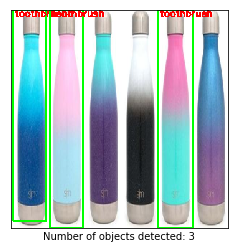

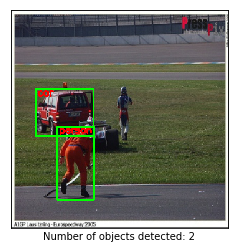

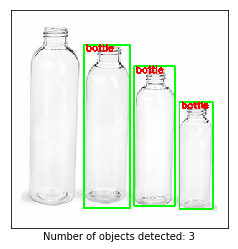

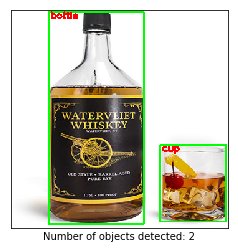

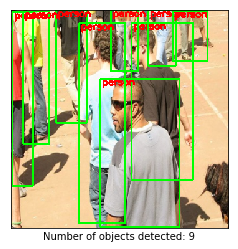

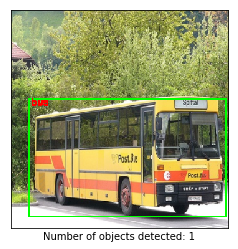

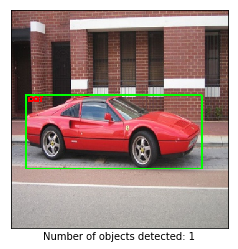

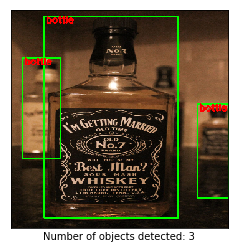

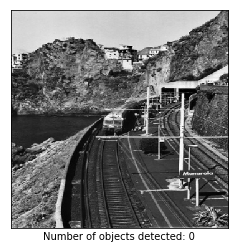

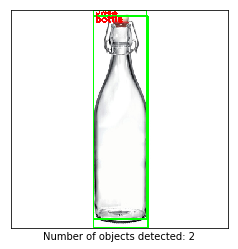

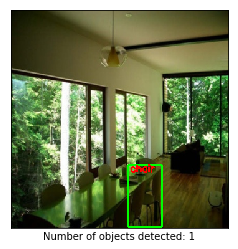

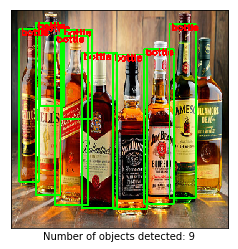

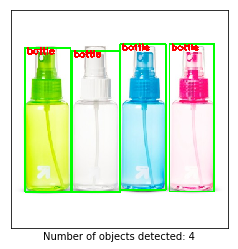

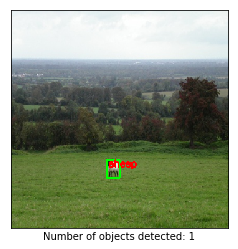

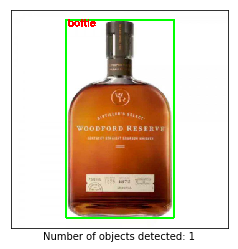

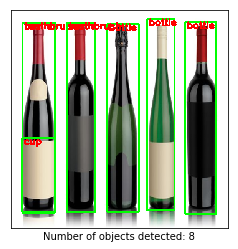

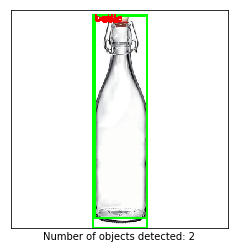

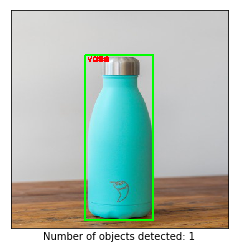

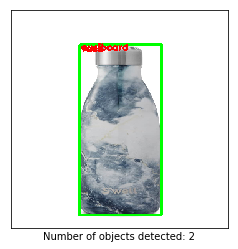

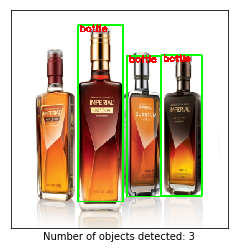

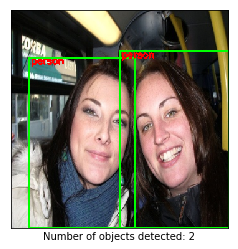

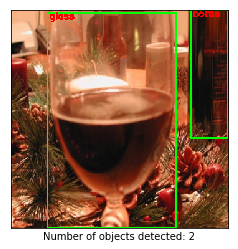

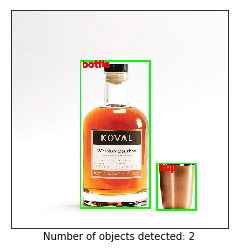

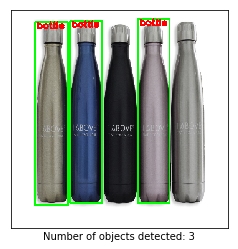

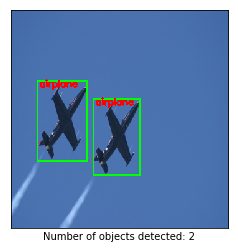

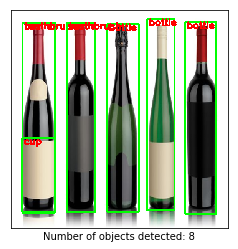

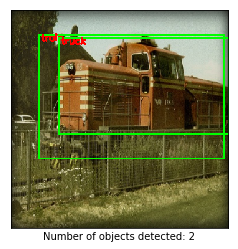

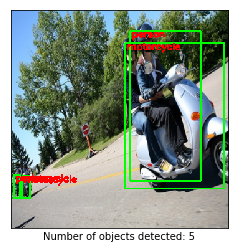

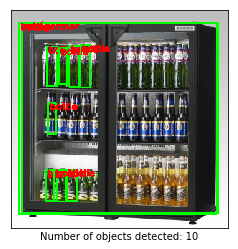

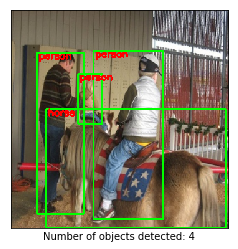

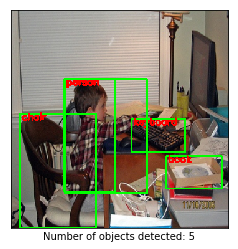

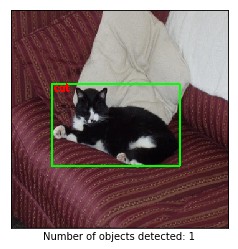

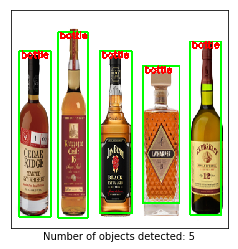

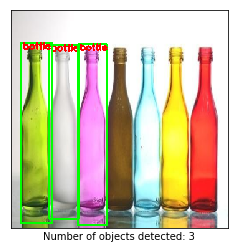

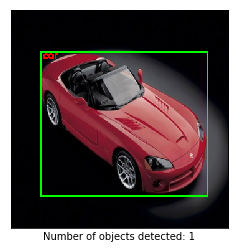

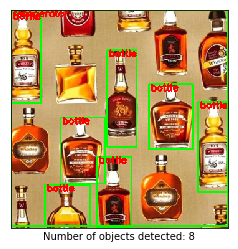

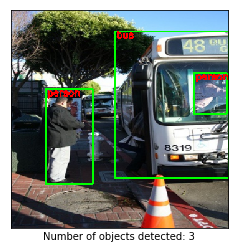

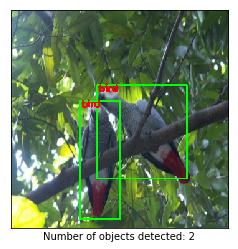

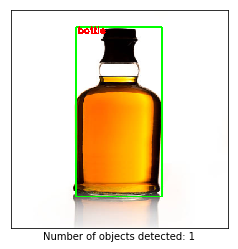

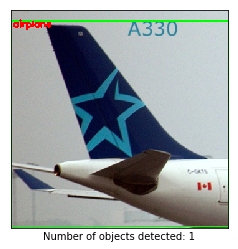

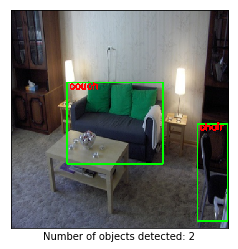

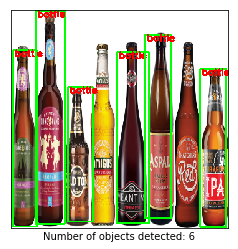

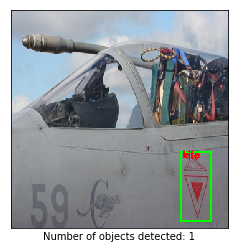

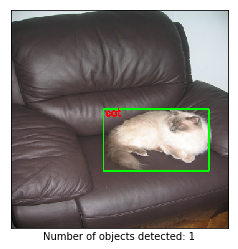

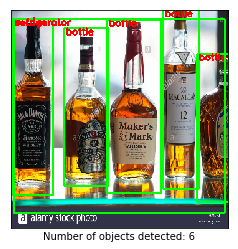

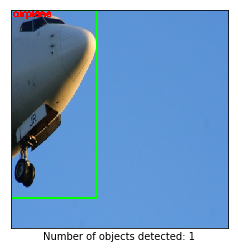

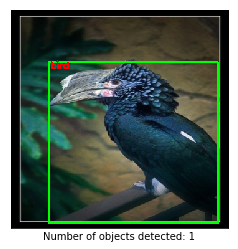

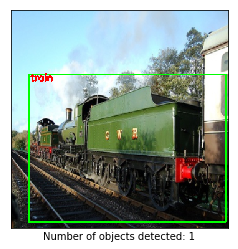

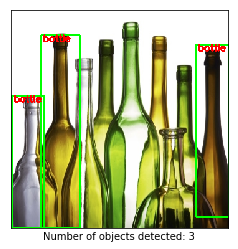

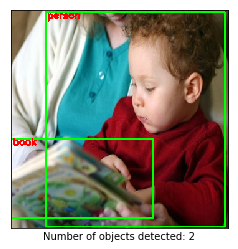

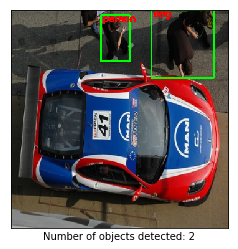

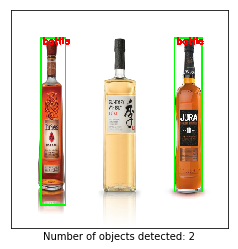

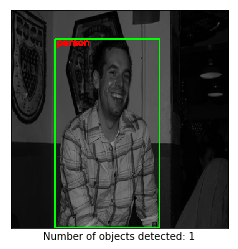

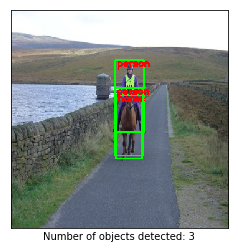

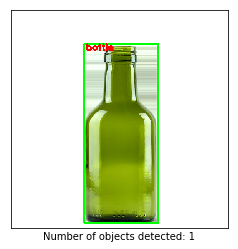

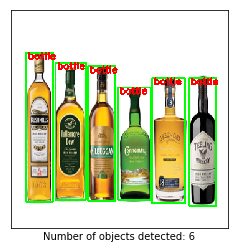

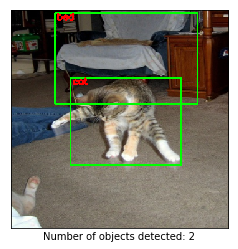

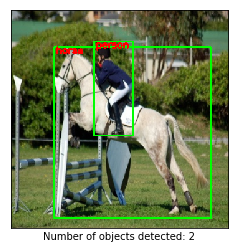

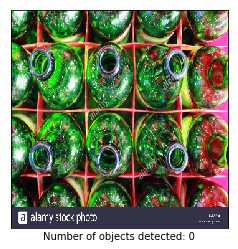

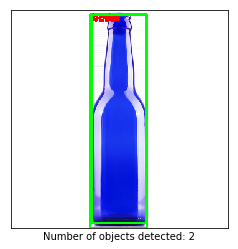

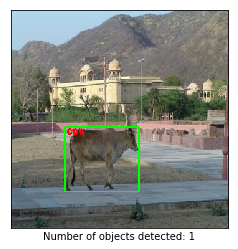

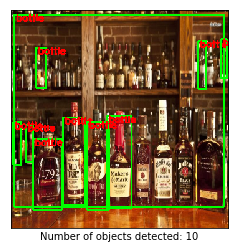

In [9]:
images = os.listdir(img_dir)
image_bat = []

for i in range(len(images)):
    image = cv2.imread(img_dir+'/'+images[i])
    image = cv2.resize(image, (im_size, im_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_bat.append(image)
    image_batch = np.asarray(image_bat)
    
    
feed_dict = {img:image_batch}
y_p_boxes, y_p_scores, y_p_num_detections, y_p_classes = sess.run([detection_boxes, 
                                                                   detection_scores, 
                                                                   num_detections, 
                                                                   detection_classes], feed_dict=feed_dict)

print(y_p_boxes.shape)
best_boxes_roi = []
best_boxes_scores = []
best_boxes_classes = []
for i in range(y_p_boxes.shape[0]):
    temp = y_p_boxes[i, :num_pred] * im_size
    best_boxes_roi.append(temp)
    best_boxes_scores.append(y_p_scores[i, :num_pred])
    best_boxes_classes.append(y_p_classes[i, :num_pred])
    
print(np.shape(best_boxes_roi))
best_boxes_roi = np.asarray(best_boxes_roi)
best_boxes_scores = np.asarray(best_boxes_scores)
best_boxes_classes = np.asarray(best_boxes_classes)
draw_boxes(image_batch, best_boxes_roi, best_boxes_classes)

In [10]:
sess.close()